In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pandas as pd
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import StratifiedKFold

In [2]:
train_data_loaded = pd.read_csv('../data/train_data_2024-08-01.csv')

X = train_data_loaded.drop(columns=['UKATEGORIE'])
y = train_data_loaded['UKATEGORIE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KFold-Konfiguration
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definieren des F-beta-Scores mit beta = 2
beta = 2
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [3]:
# Parameter-Suchräume definieren
#class_weights = ['balanced', {0: 1, 1: 2, 2: 1}, {0: 1, 1: 1, 2: 2}, None]
#class_weights = ['balanced', {0:1, 1: 1}, {0:1, 1: 3}, {0:1, 1: 6}, {0:1, 1: 7}, {0:1, 1: 8}, {0:1, 1: 9}, {0:1, 1: 10}, None]
rf_param_space = {
    'n_estimators': list(range(100, 1500, 10)),
    'max_depth': list(range(5, 30)),
    'min_samples_split': list(range(1, 200)),
    'min_samples_leaf': list(range(1, 20)),
    'max_features': ['sqrt', 'log2',8, 10, 12, 14, 16],
    #'class_weight': Categorical(class_weights)
    
}

lr_param_space = [ # weil sie kombinationen sonst fehler ergeben, alle einzeln
    {
        'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.1, 0.25, 0.5, 0.75, 1],
        'max_iter': list(range(500, 5000, 100)),
        'tol': [1e-4, 1e-3, 1e-2],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    {
        'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.1, 0.25, 0.5, 0.75, 1],
        'max_iter': list(range(500, 5000, 100)),
        'tol': [1e-4, 1e-3, 1e-2],
        'penalty': ['l2', 'l1'],
        'solver': ['liblinear']
    },
    {
        'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.1, 0.25, 0.5, 0.75, 1],
        'max_iter': list(range(500, 5000, 100)),
        'tol': [1e-4, 1e-3, 1e-2],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'solver': ['saga'],
        'l1_ratio': Real(0, 1)  # l1_ratio ist nur notwendig, wenn penalty='elasticnet'
    }
]

knn_param_space = {
    'n_neighbors': (1, 70),
    'leaf_size': (10, 50),
    'p': (1, 2),
    'weights': Categorical(['uniform', 'distance'])
}




In [4]:
# Validation function for logistic regression parameters - auch weil manche solver-penalty kombinationen nicht gehen
def validate_lr_params(params):
    if params['solver'] == 'liblinear' and params['penalty'] not in ['l1', 'l2']:
        return False
    if params['solver'] == 'lbfgs' and params['penalty'] != 'l2':
        return False
    if params['solver'] == 'saga':
        if params['penalty'] == 'elasticnet' and 'l1_ratio' not in params:
            return False
        if params['penalty'] not in ['elasticnet', 'l1', 'l2', None]:
            return False
    return True

class CustomBayesSearchCV(BayesSearchCV):
    def _get_search_params(self, *args, **kwargs):
        while True:
            params = super()._get_search_params(*args, **kwargs)
            if validate_lr_params(params):
                return params


In [5]:
# Bayessche Optimierung durchführen

# Random Forest
rf_opt = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=rf_param_space, n_iter=32, cv=kf, n_jobs=-1, scoring=fbeta_scorer, random_state=42)
rf_opt.fit(X_train, y_train)
print("Best parameters for Random Forest: ", rf_opt.best_params_)

Best parameters for Random Forest:  OrderedDict({'max_depth': 23, 'max_features': 16, 'min_samples_leaf': 4, 'min_samples_split': 38, 'n_estimators': 1220})


In [6]:
# Logistic Regression
lr_opt = CustomBayesSearchCV(estimator=LogisticRegression(), search_spaces=lr_param_space, n_iter=32, cv=kf, n_jobs=-1, scoring=fbeta_scorer, random_state=42)
lr_opt.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ", lr_opt.best_params_)

/home/kasch/Nextcloud/IKT/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kasch/Nextcloud/IKT/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Best parameters for Logistic Regression:  OrderedDict({'C': 0.75, 'max_iter': 1100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01})


In [7]:



# K-Nearest Neighbors
knn_opt = BayesSearchCV(estimator=KNeighborsClassifier(), search_spaces=knn_param_space, n_iter=32, cv=kf, n_jobs=-1, scoring=fbeta_scorer, random_state=42)
knn_opt.fit(X_train, y_train)
print("Best parameters for KNN: ", knn_opt.best_params_)

Best parameters for KNN:  OrderedDict({'leaf_size': 50, 'n_neighbors': 1, 'p': 1, 'weights': 'distance'})


In [9]:
# Modelle evaluieren
# Random Forest
rf_best = rf_opt.best_estimator_
rf_pred = rf_best.predict(X_test)
print("Random Forest Fbeta score: ", fbeta_scorer)

# Logistic Regression
lr_best = lr_opt.best_estimator_
lr_pred = lr_best.predict(X_test)
print("Logistic Regression fbeta score: ", fbeta_scorer)

# K-Nearest Neighbors
knn_best = knn_opt.best_estimator_
knn_pred = knn_best.predict(X_test)
print("KNN fbeta score: ", fbeta_scorer)

Random Forest Fbeta score:  make_scorer(fbeta_score, response_method='predict', beta=2)
Logistic Regression fbeta score:  make_scorer(fbeta_score, response_method='predict', beta=2)
KNN fbeta score:  make_scorer(fbeta_score, response_method='predict', beta=2)


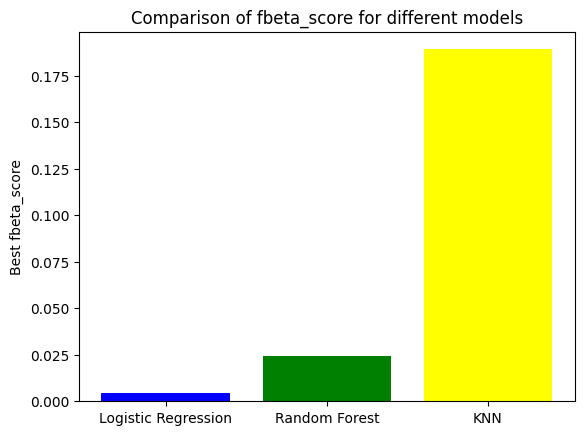

In [10]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'KNN']
scores = [lr_opt.best_score_, rf_opt.best_score_, knn_opt.best_score_]

plt.bar(models, scores, color=['blue', 'green', 'yellow'])
plt.ylabel('Best fbeta_score')
plt.title('Comparison of fbeta_score for different models')
plt.show()


In [11]:
print("Best fbeta_score for Logistic Regression: ", lr_opt.best_score_)
print("Best fbeta_score for Random Forest: ", rf_opt.best_score_)
print("Best fbeta_score for KNN: ", knn_opt.best_score_)


Best fbeta_score for Logistic Regression:  0.004574276124594433
Best fbeta_score for Random Forest:  0.024168707859817257
Best fbeta_score for KNN:  0.18919021590616064
